# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [27]:
# Load pickled data
import pickle
# TODO: Fill this in based on where you saved the training and testing data

training_file = "train.p"
testing_file = "test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [28]:
import numpy as np
# Initial data parameters after reading input
# Number of training examples
n_train = len(X_train)

# Number of testing examples.
n_test = len(X_test)

# What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# How many unique classes/labels there are in the dataset.
# use unique to get a list of sorted unique values, then count them
n_classes = len(np.unique(train['labels']))
print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Look at distribution of data

[ 210 2220 2250 1410 1980 1860  420 1440 1410 1470 2010 1320 2100 2160  780
  630  420 1110 1200  210  360  330  390  510  270 1500  600  240  540  270
  450  780  240  689  420 1200  390  210 2070  300  360  240  240]


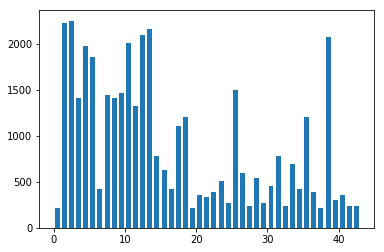

In [29]:
hist, n_bins = np.histogram(y_train, range(44))
print(hist)
center = (n_bins[:-1] + n_bins[1:]) / 2
width = 0.7 * (n_bins[1] - n_bins[0])
plt.bar(center, hist, align='center', width=width)
plt.show()


It appears that the following classes need to have data added to: 0, 6, 14, 15, 16, 19, 20, 21, 22, 23, 24, 26-34, 36, 37,39-42

In [30]:
weak_classes = [0, 6, 14, 15, 16, 19, 20, 21, 22, 23, 24, 26, 27, 28,29,30,31,32,33,34, 36, 37,39, 40, 41, 42]

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

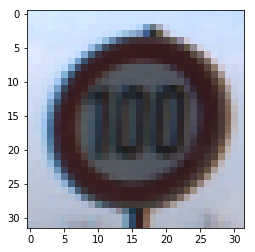

In [31]:
### Data exploration visualization goes here.
import random
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline
index = random.randint(0, len(X_train))
image = X_train[index]
plt.imshow(image)
plt.show()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

### Preprocess Data

Shuffle the training data.

In [32]:
import cv2
import numpy as np
import scipy.ndimage
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train)

## Cleanup images

improve the contrast of the images if the average color value is below some threshold (i.e. too dark) 

In [33]:
# Clean up images
threshold = 50
maxIntensity = 255.0 # depends on dtype of image data
# Parameters for manipulating image data
phi = 1
theta = 1
for index in np.arange(len(X_train)):
    avg_color = np.average([np.average(np.average(X_train[index], axis=0)),
     np.average(np.average(X_train[index], axis=1)),
     np.average(np.average(X_train[index], axis=2))])
    if avg_color < threshold:
        X_train[index] = (maxIntensity/phi)*(X_train[index]/(maxIntensity/theta))**0.5
        X_train[index] = np.array(X_train[index],dtype=np.uint8)


Try to balance the data in different classes by tripling the data in weak classes

after leveling= [ 630 2220 2250 1410 1980 1860 1260 1440 1410 1470 2010 1320 2100 2160 2340
 1890 1260 1110 1200  630 1080  990 1170 1530  810 1500 1800  720 1620  810
 1350 2340  720 2067 1260 1200 1170  630 2070  900 1080 1440]


E:\udacity\Miniconda3\envs\carnd-term1\lib\site-packages\numpy\lib\function_base.py:564: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n = np.zeros(bins, ntype)
E:\udacity\Miniconda3\envs\carnd-term1\lib\site-packages\numpy\lib\function_base.py:611: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n += np.bincount(indices, weights=tmp_w, minlength=bins).astype(ntype)


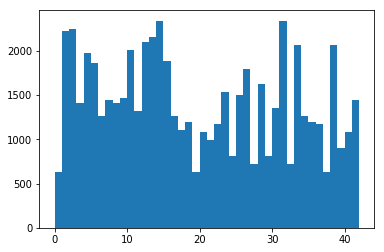

In [34]:
need_more = 0
for weak_class in weak_classes:
    need_more += 2*hist[weak_class]
shape = np.shape(X_train)
temp_train = np.zeros([need_more + shape[0],shape[1],shape[2],shape[3]])
temp_ytrain = np.zeros([need_more + shape[0]])
next = shape[0] - 1
for index in np.arange(n_train):
    temp_train[index] = X_train[index]
    temp_ytrain[index] = y_train[index]
    if y_train[index] in weak_classes:
        temp_img = scipy.ndimage.interpolation.shift(X_train[index], 
                    [random.randrange(-2, 2), random.randrange(-2, 2), 0])
        temp_img = scipy.ndimage.interpolation.rotate(temp_img,
                    random.randrange(-10, 10), reshape=False)
        temp_train[next + 1] = temp_img
        temp_ytrain[next +1] = y_train[index]
        temp_img = scipy.ndimage.interpolation.shift(X_train[index], 
                    [random.randrange(-2, 2), random.randrange(-2, 2), 0])
        temp_img = scipy.ndimage.interpolation.rotate(temp_img,
                    random.randrange(-10, 10), reshape=False)
        temp_train[next+2] = temp_img
        temp_ytrain[next+2] = y_train[index]
        next = next + 2
X_train = temp_train
y_train = temp_ytrain
hist, n_bins = np.histogram(y_train, bins=np.max(y_train))
print("after leveling=",hist)
center = (n_bins[:-1] + n_bins[1:]) / 2
width = (n_bins[1] - n_bins[0])
plt.bar(center, hist, align='center', width=width)
plt.show()

## Increase the amount of training data

Augment the data by randomizing the position and rotation of the data
From another student's findings, 5 pixels or more is too much, so we stick to 2 pixels of movement. Also rotate randomly up to 10 degrees in any direction

In [35]:
shape = np.shape(X_train)
temp_train = np.zeros([3*shape[0],shape[1],shape[2],shape[3]])
temp_ytrain = np.zeros([3*shape[0]])
for index in np.arange(n_train):
    temp_train[3*index] = X_train[index]
    temp_ytrain[3*index] = y_train[index]
    temp_img = scipy.ndimage.interpolation.shift(X_train[index], 
                [random.randrange(-2, 2), random.randrange(-2, 2), 0])
    temp_img = scipy.ndimage.interpolation.rotate(temp_img,
                random.randrange(-10, 10), reshape=False)
    temp_train[3*index+1] = temp_img
    temp_ytrain[3*index+1] = y_train[index]
    temp_img = scipy.ndimage.interpolation.shift(X_train[index], 
                [random.randrange(-2, 2), random.randrange(-2, 2), 0])
    temp_img = scipy.ndimage.interpolation.rotate(temp_img,
                random.randrange(-10, 10), reshape=False)
    temp_train[3*index+2] = temp_img
    temp_ytrain[3*index+2] = y_train[index]
X_train = temp_train
y_train = temp_ytrain
n_train = len(X_train)

#### Reshuffle the training data then generate validation data from it

Need to reshuffle since we put two identical images next to each one.
The validation data will be 20% of the training data

In [36]:
X_train, y_train = shuffle(X_train, y_train)
n_validation = int((n_train*2)/10)
X_validation = X_train[0:n_validation,:,:,:]
y_validation = y_train[0:n_validation]
X_train = X_train[n_validation:,:,:,:]
y_train = y_train[n_validation:]
# recalculate number of training examples
n_train = len(X_train)

### Clean up the test data

In [37]:
for index in np.arange(len(X_test)):
    avg_color = np.average([np.average(np.average(X_test[index], axis=0)),
     np.average(np.average(X_test[index], axis=1)),
     np.average(np.average(X_test[index], axis=2))])
    if avg_color < threshold:
        X_test[index] = (maxIntensity/phi)*(X_test[index]/(maxIntensity/theta))**0.5
        X_test[index] = np.array(X_test[index],dtype=np.uint8)

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 144497
Number of validation examples = 36124
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


## Setup TensorFlow

The EPOCH and BATCH_SIZE values affect the training speed and model accuracy. We will only cycle through the EPOCHS until the validation accuracy begins to drop

Note: GPU Not working at all on my computer in jupyter notebook, but works from IDE so I am disabling it here.

To run with GPU remove "with tf.device('/cpu:0')"

In [38]:
import tensorflow as tf

EPOCHS = 20
BATCH_SIZE = 128
dropout = 0.74  

## Implement LeNet-5
Implement the [LeNet-5](http://yann.lecun.com/exdb/lenet/) neural network architecture.

### Input
The LeNet architecture accepts a 32x32xC image as input, where C is the number of color channels. Since MNIST images are grayscale, C is 1 in this case.

### Architecture
**Layer 1: Convolutional.** The output shape should be 28x28x6.

**Activation.** Your choice of activation function.

**Pooling.** The output shape should be 14x14x6.

**Layer 2: Convolutional.** The output shape should be 10x10x16.

**Activation.** Your choice of activation function.

**Pooling.** The output shape should be 5x5x16.

**Flatten.** Flatten the output shape of the final pooling layer such that it's 1D instead of 3D. The easiest way to do is by using `tf.contrib.layers.flatten`, which is already imported for you.

**Layer 3: Fully Connected.** This should have 120 outputs.

**Activation.** Your choice of activation function.

**Layer 4: Fully Connected.** This should have 84 outputs.

**Activation.** Your choice of activation function.

**Layer 5: Fully Connected (Logits).** This should have 43 outputs.

### Output
Return the result of the 2nd fully connected layer.

### Initialize the variables first
We will need access to the variables for the regularization algorithm. 
The original LeNet algorithm we were given defined the variables inside
The LeNet function

In [39]:
with tf.device('/cpu:0'):
    mu = 0
    sigma = 0.1
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, n_classes), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(n_classes))

In [40]:
from tensorflow.contrib.layers import flatten

def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Activation of Layer 1
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Output = 10x10x16.
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # Activation.
    conv2 = tf.nn.relu(conv2)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Activation.
    fc1    = tf.nn.relu(fc1)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Activation.
    fc2    = tf.nn.relu(fc2)
    fc2 = tf.nn.dropout(fc2, dropout)

    # Layer 5: Fully Connected. Input = 84. Output = n_classes.
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

## Features and Labels
Train LeNet to classify data.

`x` is a placeholder for a batch of input images.
`y` is a placeholder for a batch of output labels.
Note that there is a bug in the one_hot implementation that forces us to implement one_hot by hand... 
see https://github.com/tensorflow/tensorflow/issues/6509

In [41]:
with tf.device('/cpu:0'): 
    x = tf.placeholder(tf.float32, (None, 32, 32, 3))
    y = tf.placeholder(tf.int32, (None))

    # implement one hot
    num_labels = n_classes
    sparse_labels = tf.reshape(y, [-1, 1])
    derived_size = tf.shape(sparse_labels)[0]
    indices = tf.reshape(tf.range(0, derived_size, 1), [-1, 1])
    concated = tf.concat(1, [indices, sparse_labels])
    outshape = tf.concat(0, [tf.reshape(derived_size, [1]), tf.reshape(num_labels, [1])])
    one_hot_y = tf.sparse_to_dense(concated, outshape, 1.0, 0.0)

## Training Pipeline
Create a training pipeline that uses the model to classify the data.

The learning rate was slower than the initial value because of the large amount of data. 

Regularization was added as the sum of the weights times some value beta

In [42]:
with tf.device('/cpu:0'):
    rate = 0.0005

    logits = LeNet(x)
    beta = 0.0012
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
    loss_operation = tf.reduce_mean(cross_entropy +
        beta*tf.nn.l2_loss(conv1_W) +
        beta*tf.nn.l2_loss(conv2_W) +
        beta*tf.nn.l2_loss(fc1_W) +
        beta*tf.nn.l2_loss(fc2_W) +
        beta*tf.nn.l2_loss(fc2_W))
    optimizer = tf.train.AdamOptimizer(learning_rate = rate)
    training_operation = optimizer.minimize(loss_operation)

## Model Evaluation
Evaluate how well the loss and accuracy of the model for a given dataset.

In [43]:
with tf.device('/cpu:0'):
    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
    accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    saver = tf.train.Saver()

    def evaluate(X_data, y_data):
        num_examples = len(X_data)
        total_accuracy = 0
        sess = tf.get_default_session()
        for offset in range(0, num_examples, BATCH_SIZE):
            batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
            accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
            total_accuracy += (accuracy * len(batch_x))
        return total_accuracy / num_examples

## Train the Model
Run the training data through the training pipeline to train the model.

Before each epoch, shuffle the training set.

After each epoch, measure the loss and accuracy of the validation set.

Save the model after training.

Note that we have a maximum number of EPOCHs. However, to avoid overlearning we stop when the validation accuracy has decreased

Question: Should we blindly evaluate the model on each EPOCH but ignore it until the accuracy decreases then use the last one?

In [44]:
with tf.device('/cpu:0'):
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        num_examples = len(X_train)

        print("Training...")
        print()
        last_validation_accuracy = 0
        for i in range(EPOCHS):
            X_train, y_train = shuffle(X_train, y_train)
            for offset in range(0, num_examples, BATCH_SIZE):
                end = offset + BATCH_SIZE
                batch_x, batch_y = X_train[offset:end], y_train[offset:end]
                sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})

            validation_accuracy = evaluate(X_validation, y_validation)
            print("EPOCH {} ...".format(i+1))
            print("Validation Accuracy = {:.3f}".format(validation_accuracy))
            print()
            # if we're not improving, we're done
            if(last_validation_accuracy > validation_accuracy):
                break
            else:
                last_validation_accuracy = validation_accuracy

        saver.save(sess, './lenet')
        print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.652

EPOCH 2 ...
Validation Accuracy = 0.785

EPOCH 3 ...
Validation Accuracy = 0.860

EPOCH 4 ...
Validation Accuracy = 0.896

EPOCH 5 ...
Validation Accuracy = 0.917

EPOCH 6 ...
Validation Accuracy = 0.929

EPOCH 7 ...
Validation Accuracy = 0.946

EPOCH 8 ...
Validation Accuracy = 0.949

EPOCH 9 ...
Validation Accuracy = 0.961

EPOCH 10 ...
Validation Accuracy = 0.968

EPOCH 11 ...
Validation Accuracy = 0.967

Model saved


## Evaluate the Model
Once you are completely satisfied with your model, evaluate the performance of the model on the test set.

Be sure to only do this once!

If you were to measure the performance of your trained model on the test set, then improve your model, and then measure the performance of your model on the test set again, that would invalidate your test results. You wouldn't get a true measure of how well your model would perform against real data.

In [60]:
with tf.device('/cpu:0'):
    with tf.Session() as sess:
        saver.restore(sess, tf.train.latest_checkpoint('.'))

        test_accuracy = evaluate(X_test, y_test)
        print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.907


### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**

### We increased the amount of data by a factor of 3
This had a significant effect by moving the maximum test accuracy from 88% to almost 93%. This was done by augmenting the data using the technique used by another student:
https://medium.com/@paramaggarwal/intricacies-of-traffic-sign-classification-with-tensorflow-8f994b1c8ba

### Split the data into training/validation/testing sets here

The test data was already given, the validation data was about 20% of the total data, which is something I believe came from the recommendation in the course as well as a recommendation in Andrew Ng's Machine Learning course.

### Improve Data Contrast

Some of the data was very dark. Using a technique to stretch the colors using an alpha and beta value, we improved the contrast. 

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

After cleaning up the training data, we took 20% of it after randomizing it
and made it into the validation data set

The original data set was an set of images ordered by class. The resulting set was randomized, augmented then randomized again.

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:** The LeNet model provides a good way to process small images out of the box. The model we were provided processes 32x32 color images with little or no changes. This gives us a five layer neural network model. The more layers of a neural network you have, the better the result, but the longer it will take to train and the more "horsepower" you need to calculate it. Here, we have two layers that are partially connected, and three that are fully connected.

**Layer 1: Convolutional.** The first layer takes the inputs and convolves it with a 6x6 filter. The result is a 28x28x6 output.

**Activation.** I chose the RELU, or REctified Linear Unit function. This activation function gives you a linear output for values > 0, and 0 for values less than or equal to 0. It is differentiable everywhere, so allows one to use it in an environment where backpropagation is used as that requires a continuous activation function. In other cases I have used the logistic function with good results.

**Pooling.** The pixel level may be too granular for finding features, so here we use pooling around 2x2 pixels. The output shape should be 14x14x6.
The formula for the pooling filter size is:
new_height = (input_height - filter_height)/S + 1
new_width = (input_width - filter_width)/S + 1

Her the input height is 28, input width is 28, new height and width are 14. Assuming the Stride is 2, that gives us a filter size of 2x2

**Layer 2: Convolutional.** now we convolve it with a  10x10x16.

**Activation.** To be consistent, I used RELU again

**Pooling.**  The output shape should be 5x5x16. Again using the above formula to find it.

**Flatten.** Flatten the output shape of the final pooling layer such that it's 1D instead of 3D. The easiest way to do is by using `tf.contrib.layers.flatten` This gives us 5x5x16 or 400 outputs.

**Layer 3: Fully Connected.** This should have 120 outputs. We do this by creating a weight matrix of 120x400

**Activation.** To be consistent, I used RELU again

**Layer 4: Fully Connected.** This should have 84 outputs. We do this by creating a weight matrix of 84x120

**Activation.** to be consistent, we use RELU again

**Layer 5: Fully Connected (Logits).** This should have 43 outputs, corresponding to each of the classes. We do this by building an 84x43 weight matrix

Once we have the logits, we can put them through a softmax function to find the probabilities.

Note that I did not change the model from the original structure for LeNet. There were many hyperparameters to tune without doing that and we achieved the goal.

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:** We used the default AdamOptimizer but added a dropout of 75% and regularization with a beta of 0.0012. We left the default batch size of 128 (my GPU is barely acceptable to tensorflow, so I didn't want to push that), and a maximum of 20 epochs.

To prevent overfiting the training data, we used the maximum Validation accuracy as a cutoff. So if the 11th Epoch had a validation accuracy smaller than the 10th epoch we stopped there

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:** The LeNet model provides a good way to process small images out of the box. The model we were provided processes 32x32 color images with little or no changes. This gives us a five layer neural network model. The more layers of a neural network you have, the better the result, but the longer it will take to train and the more "horsepower" you need to calculate it. 

Starting the the default LeNet model presented to us, I tweaked the learning rate,dropout rate, and regularization functions to try to get the best validation accuracy, When I hit a wall on that at 88%, I did more research and found that increasing the amount of training data might improve accuracy even more than tweaking these parameters. 

Once I did that, I discovered that the accuracy had actually decreased somewhat. I guessed that because the volume of data had increased, that the learning rate was overfitting the data. On decreasing the learning rate slightly, I was able to achieve a Validation Accuracy of 96.5% and a test accuracy of almost 92%

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook.

I found 5 images on the network. They all start out as much larger than 32x32 and whatever I do to reduce them will probably distort them in some manner. Also, it is possible that the colors may not match those in the training or test set, as I derived them from different sources

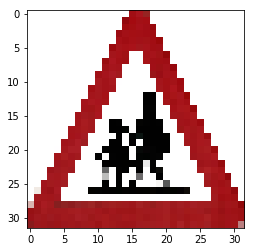

In [46]:
from scipy import misc
img_temp = misc.imread('E:/udacity/CarND-Traffic-Sign-Classifier-Project/children-crossing-triangle-sign.jpg')
img1 = cv2.resize(img_temp,(32,32), interpolation=cv2.INTER_LINEAR)
plt.imshow(img1)

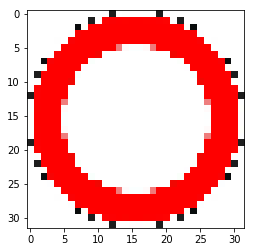

In [47]:
img_temp = misc.imread('E:/udacity/CarND-Traffic-Sign-Classifier-Project/no-vehicles-traffic-sign-sign-road-sign.jpg')
img2 = cv2.resize(img_temp,(32,32))
plt.imshow(img2)

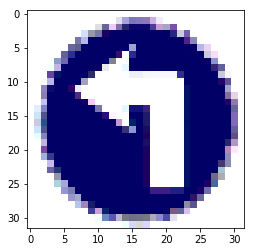

In [48]:
img_temp = misc.imread('E:/udacity/CarND-Traffic-Sign-Classifier-Project/turn_left_ahead.gif')
img3 = cv2.resize(img_temp,(32,32))
plt.imshow(img3)

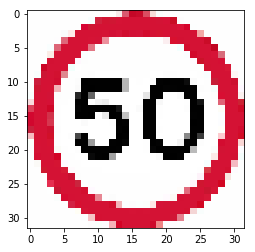

In [49]:
img_temp = misc.imread('E:/udacity/CarND-Traffic-Sign-Classifier-Project/uk-50mph-speed-limit-sign.jpg')
img4 = cv2.resize(img_temp,(32,32))
plt.imshow(img4)

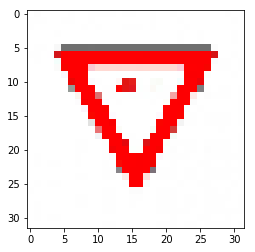

In [50]:
img_temp = misc.imread('E:/udacity/CarND-Traffic-Sign-Classifier-Project/yield-sign.jpg')
img5 = cv2.resize(img_temp,(32,32))
plt.imshow(img5)

**Answer:**

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


In [61]:
with tf.device('/cpu:0'):
    with tf.Session() as sess:
        saver.restore(sess, tf.train.latest_checkpoint('.'))

        test_accuracy = evaluate([img1,  img2, img3, img4, img5], [28, 15, 34,  2, 13])
        print("Test Accuracy for images = {:.3f}".format(test_accuracy))        

Test Accuracy for images = 0.800


**Answer:**

The model was able to handle 4 of the 5 images successfully

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [80]:
with tf.device('/cpu:0'):
    with tf.Session() as sess:
        saver.restore(sess, tf.train.latest_checkpoint('.'))
        pred = sess.run(tf.nn.softmax(logits), feed_dict={x:[img1, img2, img3, img4, img5]}) 
        print(sess.run(tf.nn.top_k(pred,k=5)))

TopKV2(values=array([[  9.97914851e-01,   1.96044170e-03,   8.48421259e-05,
          3.98820557e-05,   2.47959386e-09],
       [  1.00000000e+00,   1.53639390e-18,   2.31978768e-24,
          4.54355039e-25,   3.26786678e-26],
       [  9.01683033e-01,   9.82301906e-02,   6.55447366e-05,
          2.10350590e-05,   1.98986584e-07],
       [  8.82770240e-01,   3.44403386e-02,   2.59099454e-02,
          2.25888193e-02,   1.26396548e-02],
       [  1.00000000e+00,   1.89073313e-19,   2.92873162e-23,
          1.15161282e-29,   1.57824428e-32]], dtype=float32), indices=array([[28, 26, 20, 29, 22],
       [15, 32, 36, 13,  8],
       [35, 34, 12, 13, 37],
       [31, 21, 40, 11,  1],
       [13, 17, 12, 25, 14]]))


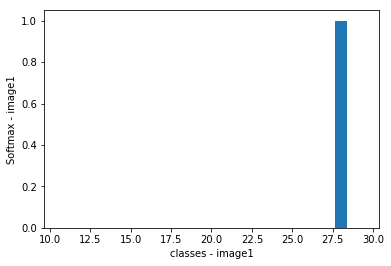

In [81]:
        plt.bar([28, 20, 29, 27, 11], [1, 0, 0, 0,0])
        plt.xlabel('classes - image1')
        plt.ylabel('Softmax - image1')
        plt.show()

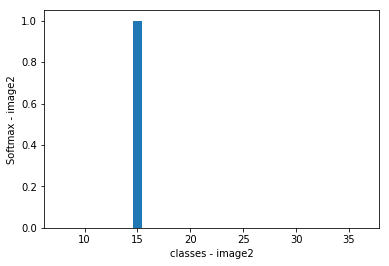

In [82]:
        plt.bar([15, 32, 36, 13,  8], [1, 0, 0, 0,0])
        plt.xlabel('classes - image2')
        plt.ylabel('Softmax - image2')
        plt.show()

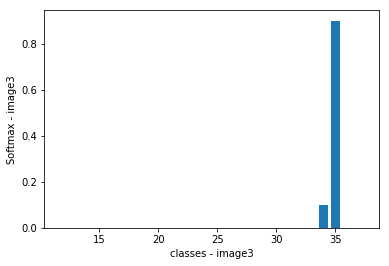

In [83]:
        plt.bar([35, 34, 12, 13, 37], [0.902, 0.0982, 0, 0,0])
        plt.xlabel('classes - image3')
        plt.ylabel('Softmax - image3')
        plt.show()

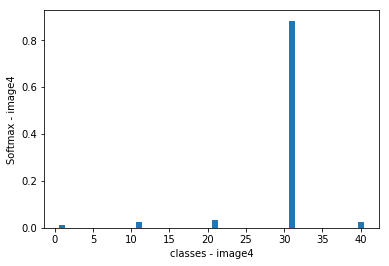

In [85]:
plt.bar([31, 21, 40, 11,  1], [0.883, 0.0344, 0.0259, 0.0226,0.0126])
plt.xlabel('classes - image4')
plt.ylabel('Softmax - image4')
plt.show()

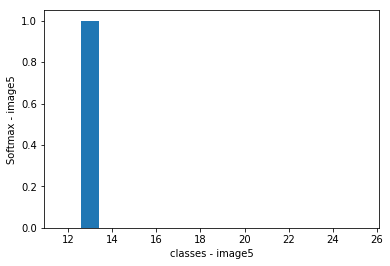

In [88]:
plt.bar([13, 17, 12, 25, 14], [1, 0,0 ,0,0])
plt.xlabel('classes - image5')
plt.ylabel('Softmax - image5')
plt.show()

**Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.